In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import numpy as np
import scipy.signal as sig
import keras

from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model
from keras.models import load_model
from keras import regularizers
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path



Using TensorFlow backend.


## Load data and Preprocessing

In [2]:
# fix random seed for reproducibility
np.random.seed(8)

data = np.genfromtxt('IRIS.txt')
#data = np.genfromtxt('H1O1O2_GPR_earthquakes.txt')
print (len(data))

733208


In [3]:
## perhaps  if we cut out the IRIS P waves we can get better results## 
#going to chooose <6000 

#for IRIS 

eqgpstime = data[:,1]
peakgpstime = data[:,17]
arrivaltime = np.subtract(peakgpstime,eqgpstime)
distance = data[:,13]
Velocity = np.divide(distance, arrivaltime)
#pwaveomit = 6000
#data = data[Velocity<6000]
#print (len(data))

#for L10102, H10102, V10102

#eqgpstime = data[:,0]
#peakgpstime = data[:,24]
#arrivaltime = np.subtract(peakgpstime,eqgpstime)
#distance = data[:,12]
#Velocity = np.divide(distance, arrivaltime)
#pwaveomit = 6000
#data = data[Velocity<6000]
print (len(data))

733208


## To exclude non-land points

In [4]:
#This cell excludes Earthquakes not on land
#Warning: takes a while to run.

#eq_lat2 = data[:,11] # iris
#eq_lon2 = data[:,12] #iris

#eq_lat2 = data[:,10] #L10102, H10102, V10102
#eq_lon2 = data[:,11] #L10102, H10102, V10102
#map1 = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50, resolution='h')
#lats = eq_lat2                                                                                                         \
                                                                                                                                
#lons = eq_lon2
#x, y = map1(lons, lats)
#locations = np.c_[x, y]
#polygons = [Path(p.boundary) for p in map1.landpolygons]
#result = np.zeros(len(locations), dtype=bool)
#for polygon in polygons:
#    result += np.array(polygon.contains_points(locations))


#print (len(data))
#data =data[result]
print (len(data))



733208


In [5]:


# Extract X and y and divide into train, val, and test set
X = data[:, [2, 11, 12, 13, 14, 15]]#iris
#X = data[:, [1, 10, 11, 12, 13, 14]] #L10102, H10102, V10102

Z = np.log10(data[:, 18]) #iris
#Z = np.log10(data[:, 25])  #L10102, H10102, V10102
print(X.shape)

y =np.subtract((data[:,17 ]),(data[:, 1])) #iris
#y =np.subtract((data[:,24 ]),(data[:, 0])) #L10102, H10102, V10102
#print(y)

#cutting out earthquakes with a ground velocity less 1e-6
mask = Z > -6.0

y = y[mask]
X = X[mask]



# Normalizing
X -= np.mean(X, axis=0) 
X /= np.std(X, axis=0)

mean_y = np.mean(y, axis=0)
stdv_y = np.std(y, axis=0)
y = (y-mean_y)/stdv_y

# Shuffle and divide into train and val set
mask = np.random.permutation(X.shape[0]) 
X = X[mask]
y = y[mask]

tfrac = int(0*y.size) #In training 0.8 but 0 here since testing against all data
#X_train = X[:tfrac]
#y_train = y[:tfrac]
X_val = X[tfrac:]
y_val = y[tfrac:]

#print('X_train shape: {}'.format(X_train.shape))
#print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))


(733208, 6)
X_val shape: (700453, 6)
y_val shape: (700453,)


## Load Model 

In [6]:
model = load_model('allirisavtoat.hdf5')

## Predict

In [7]:
y_pred = model.predict(X_val) 
# Inverse-normalize
y_val = y_val*stdv_y + mean_y
y_pred = y_pred*stdv_y + mean_y

(700453,)
(700453,)
[4004.8975 2066.0015 4078.0327 ... 1706.282  2704.4683 2211.3147]


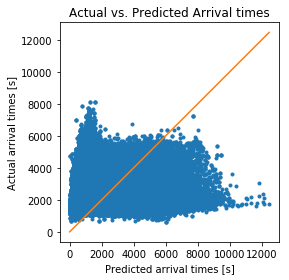

In [8]:
print(y_val.shape)
y_pred = y_pred.flatten()

print(y_pred.shape)
print(y_pred)
fig, ax = plt.subplots()

y_val = abs(y_val)
y_pred = abs(y_pred)

v_min = min(np.min(y_val), np.min(y_pred))
v_max = max(np.max(y_val), np.max(y_pred))
x = np.linspace(v_min, v_max, 1000)


ax.plot(y_val, y_pred, '.')
ax.plot(x, x)
ax.set(title= 'Actual vs. Predicted Arrival times', xlabel='Predicted arrival times [s]', ylabel='Actual arrival times [s]')

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('allirisoniris1.png', dpi =300,bbox_inches='tight')
#plt.savefig('VIRATtest.png', dpi =300,bbox_inches='tight')
plt.show()

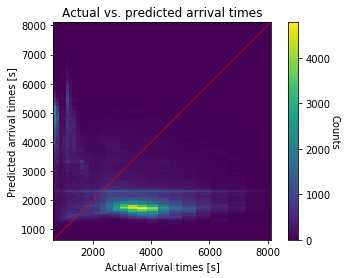

In [9]:
x = np.linspace(v_min, v_max, 1000)
fig2, ax, = plt.subplots()
x_bins = np.logspace(np.log10(y_val.min()), np.log10(y_val.max()),np.sqrt(10000)) #12279
y_bins = np.logspace(np.log10(y_pred.min()), np.log10(y_pred.max()),np.sqrt(10000))
H, xedges, yedges = np.histogram2d(y_val, y_pred, bins=[x_bins,y_bins])
#ax2 = fig.add_subplot(212)
h = ax.pcolormesh(xedges, yedges, H.T)

ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
ax.set(ylabel='Predicted arrival times [s]', xlabel='Actual Arrival times [s]',title = 'Actual vs. predicted arrival times')

cbar = plt.colorbar(h, ax=ax)
ax.plot(x, x, c='r',linewidth=.5)

cbar.set_label('Counts', rotation=270,labelpad=9)

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('allirisonirisdensity1.png', dpi =300,bbox_inches='tight')

plt.show()

(700453,)
2.7471667752617277e-06
2794.802713399699
1.4375486543565594


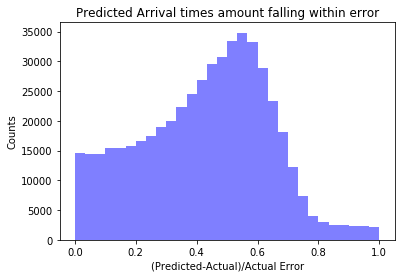

In [10]:
z = np.array(abs((y_val -y_pred)/y_val))

print(z.shape)
print(np.min(z))
print(np.max(z))
print (np.average(z))

plt.hist(z, bins=30,range =[0,1], facecolor='blue', alpha=0.5)
plt.xlabel('(Predicted-Actual)/Actual Error')
plt.ylabel('Counts')
plt.title('Predicted Arrival times amount falling within error')
plt.savefig('allirisonirishist2.png', dpi =300,bbox_inches='tight')
plt.show()